In [519]:
import numpy as np
import matplotlib.pyplot as plt

from ink_detection_utils import load_dataset
from ink_detection_utils import get_crop_numer_list
from ink_detection_utils import stitch_crops

from PIL import Image

%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [68]:
VESUVIUS_DATA_PATH = '../../Datasets/vesuvius-challenge-ink-detection/'

layer_depth = 24

In [234]:
train_dataset = load_dataset(VESUVIUS_DATA_PATH, dataset = 'train')

Fragment: 1 Loaded: crop_100.png
Fragment: 1 Loaded: crop_1000.png
Fragment: 1 Loaded: crop_1001.png
Fragment: 1 Loaded: crop_1002.png
Fragment: 1 Loaded: crop_1003.png
Fragment: 1 Loaded: crop_1004.png
Fragment: 1 Loaded: crop_1005.png
Fragment: 1 Loaded: crop_1006.png
Fragment: 1 Loaded: crop_1007.png
Fragment: 1 Loaded: crop_1008.png
Fragment: 1 Loaded: crop_1009.png
Fragment: 1 Loaded: crop_101.png
Fragment: 1 Loaded: crop_1010.png
Fragment: 1 Loaded: crop_1011.png
Fragment: 1 Loaded: crop_1012.png
Fragment: 1 Loaded: crop_1013.png
Fragment: 1 Loaded: crop_102.png
Fragment: 1 Loaded: crop_1027.png
Fragment: 1 Loaded: crop_1028.png
Fragment: 1 Loaded: crop_1029.png
Fragment: 1 Loaded: crop_103.png
Fragment: 1 Loaded: crop_1030.png
Fragment: 1 Loaded: crop_1031.png
Fragment: 1 Loaded: crop_1032.png
Fragment: 1 Loaded: crop_1033.png
Fragment: 1 Loaded: crop_1034.png
Fragment: 1 Loaded: crop_1035.png
Fragment: 1 Loaded: crop_1036.png
Fragment: 1 Loaded: crop_1037.png
Fragment: 1 Loaded

In [235]:
train_dataset[0][0].shape

(1308, 65, 70, 70, 3)

In [236]:
train_dataset[0][1].shape

(1308, 70, 70, 3)

In [237]:
frag_1_volumes = train_dataset[0][0]
frag_1_labels = train_dataset[0][1]

frag_1_volumes = frag_1_volumes[:,:,:,:,0]
frag_1_labels = frag_1_labels[:,:,:,0]/255

In [238]:
frag_1_volumes.shape

(1308, 65, 70, 70)

In [239]:
frag_1_labels.shape

(1308, 70, 70)

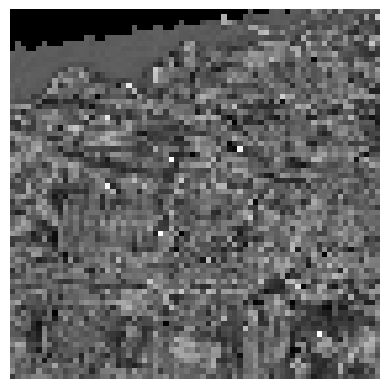

In [240]:
# Display the grayscale image
plt.imshow(frag_1_volumes[0][0], cmap="gray") #last [] is the layer
plt.axis("off")
plt.show()

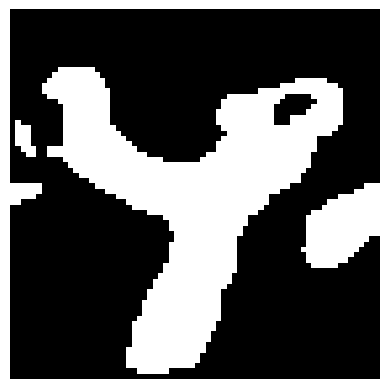

In [241]:
# Display the grayscale image
plt.imshow(frag_1_labels[0], cmap="gray")
plt.axis("off")
plt.show()

In [242]:
frag_1_volumes[0][0].shape

(70, 70)

In [243]:
frag_1_labels[0].shape

(70, 70)

In [244]:
frag_1_labels[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [245]:
frag_1_volumes = frag_1_volumes.reshape(frag_1_volumes.shape[0],frag_1_volumes.shape[1],70,70)
frag_1_labels = frag_1_labels.reshape(frag_1_volumes.shape[0],1,70,70)

In [246]:
#Do this processing for all fragments

for i in range(len(train_dataset)):
    train_dataset[i][0] = train_dataset[i][0][:,:,:,:,0]
    train_dataset[i][1] = train_dataset[i][1][:,:,:,0]/255

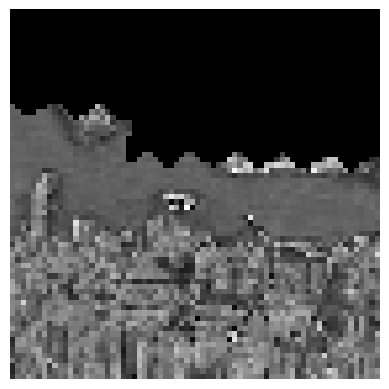

In [247]:
# Display the grayscale image
plt.imshow(train_dataset[1][0][0][0], cmap="gray") # [fragment][train][layer][image]
plt.axis("off")
plt.show()

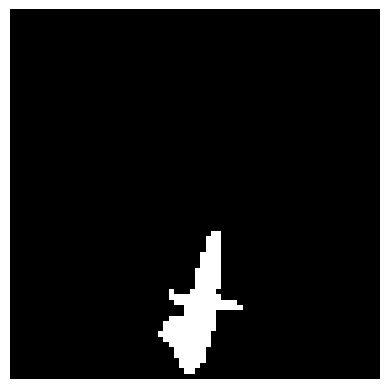

In [248]:
# Display the grayscale image
plt.imshow(train_dataset[1][1][0], cmap="gray") # [fragment][label][image]
plt.axis("off")
plt.show()

In [249]:
train_dataset[1][0][0][0].shape

(70, 70)

In [250]:
train_dataset[1][1][0].shape

(70, 70)

In [251]:
for i in range(len(train_dataset)):
    train_dataset[i][0] = train_dataset[i][0].reshape(train_dataset[i][0].shape[0],train_dataset[i][0].shape[1],70,70)
    train_dataset[i][1] = train_dataset[i][1].reshape(train_dataset[i][1].shape[0],1,70,70)

In [252]:
train_dataset[1][0][0][0].shape

(70, 70)

In [253]:
train_dataset[1][1][0].shape

(1, 70, 70)

In [254]:
# Concatenate the arrays along the first dimension
volume_data = np.concatenate([arr[0] for arr in train_dataset], axis=0)
label_data = np.concatenate([arr[1] for arr in train_dataset], axis=0)

In [256]:
volume_data = volume_data[:,:layer_depth,:,:,]
volume_data.shape

(6938, 24, 70, 70)

In [257]:
label_data.shape

(6938, 1, 70, 70)

In [258]:
# Test-train split
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets while preserving label balance
X_train, X_val, Y_train, Y_val = train_test_split(volume_data, label_data, test_size=0.1)

In [259]:
print("Train images shape:",X_train.shape)
print("Train labels shape:",Y_train.shape)
print("Validation images shape:",X_val.shape)
print("Validation labels shape:",Y_val.shape)

Train images shape: (6244, 24, 70, 70)
Train labels shape: (6244, 1, 70, 70)
Validation images shape: (694, 24, 70, 70)
Validation labels shape: (694, 1, 70, 70)


In [595]:
#UNet Implementation

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as func

from torch.utils.data import DataLoader, Dataset

In [617]:
torch.cuda.empty_cache()

In [618]:
# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [598]:
class CharacterDataset(Dataset):
    def __init__(self, images, labels):
        self.images = torch.FloatTensor(images)
        self.labels = torch.FloatTensor(labels)

        self.images = self.images.to(device)
        self.labels = self.labels.to(device)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        return image, label

In [599]:
train_dataset = CharacterDataset(X_train, Y_train)
val_dataset = CharacterDataset(X_val, Y_val)

In [600]:
#Simple UNet Model without skip connections

class UNetWithoutSkipConnections(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNetWithoutSkipConnections, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3, stride=1), # 68x68x16
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 34x34x16

            nn.Conv2d(16, 32, kernel_size=3, stride=1), # 32x32x32
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 16x16x32

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), # 16x16x64
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 8x8x64

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), # 8x8x128
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # 4x4x128
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, out_channels, kernel_size=2, stride=2, padding=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

Epoch 0 Processing Batch No: 1
Epoch 0 Processing Batch No: 2
Epoch 0 Processing Batch No: 3
Epoch 0 Processing Batch No: 4
Epoch 0 Processing Batch No: 5
Epoch 0 Processing Batch No: 6
Epoch 0 Processing Batch No: 7
Epoch 0 Processing Batch No: 8
Epoch 0 Processing Batch No: 9
Epoch 0 Processing Batch No: 10
Epoch 0 Processing Batch No: 11
Epoch 0 Processing Batch No: 12
Epoch 0 Processing Batch No: 13
Epoch 0 Processing Batch No: 14
Epoch 0 Processing Batch No: 15
Epoch 0 Processing Batch No: 16
Epoch 0 Processing Batch No: 17
Epoch 0 Processing Batch No: 18
Epoch 0 Processing Batch No: 19
Epoch 0 Processing Batch No: 20
Epoch 0 Processing Batch No: 21
Epoch 0 Processing Batch No: 22
Epoch 0 Processing Batch No: 23
Epoch 0 Processing Batch No: 24
Epoch 0 Processing Batch No: 25
Epoch 0 Processing Batch No: 26
Epoch 0 Processing Batch No: 27
Epoch 0 Processing Batch No: 28
Epoch 0 Processing Batch No: 29
Epoch 0 Processing Batch No: 30
Epoch 0 Processing Batch No: 31
Epoch 0 Processin

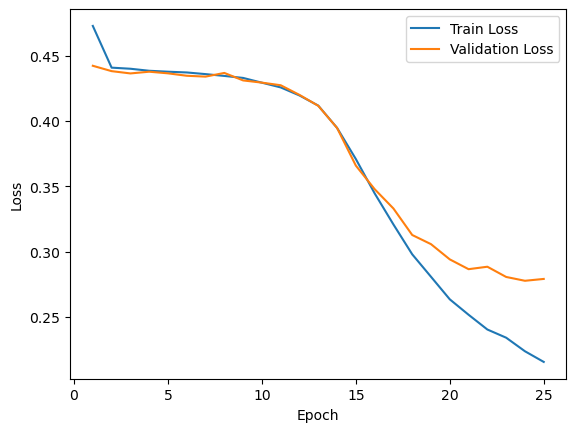

In [619]:
model = UNetWithoutSkipConnections(in_channels=layer_depth, out_channels=1)
model = model.to(device)

criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 25
batch_size = 64

best_test_loss = float('inf')
best_model_state = None

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

train_losses = []
test_losses = []

for epoch in range(num_epochs):
    train_loss = 0.0
    test_loss = 0.0

    # Training
    model.train()

    batch_no = 1

    for batch in train_loader:

        print('Epoch',epoch,'Processing Batch No:', batch_no)

        images, labels = batch

        # Forward pass
        reconstructions = model(images)
        loss = criterion(reconstructions, labels.float())

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)

        batch_no = batch_no + 1

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Evaluation
    model.eval()
    with torch.no_grad():
        for batch in val_loader:
            images, labels = batch

            # Forward pass
            reconstructions = model(images)
            loss = criterion(reconstructions, labels.float())

            test_loss += loss.item() * images.size(0)

        test_loss /= len(val_loader.dataset)
        test_losses.append(test_loss)

        # Check if current model has the lowest test loss so far
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            best_model_state = model.state_dict().copy()

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

# Plotting train and test loss
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), test_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Load the best model state (lowest test loss)
model.load_state_dict(best_model_state)
torch.save(model, '../models/ink_detection_simple_u_net_epoch_'+str(num_epochs)+'_batch_'+str(batch_size)+'.pt')

In [440]:
test_dataset = load_dataset(VESUVIUS_DATA_PATH, dataset = 'test')

Fragment: a Loaded: crop_100.png
Fragment: a Loaded: crop_101.png
Fragment: a Loaded: crop_102.png
Fragment: a Loaded: crop_103.png
Fragment: a Loaded: crop_104.png
Fragment: a Loaded: crop_105.png
Fragment: a Loaded: crop_106.png
Fragment: a Loaded: crop_107.png
Fragment: a Loaded: crop_108.png
Fragment: a Loaded: crop_109.png
Fragment: a Loaded: crop_110.png
Fragment: a Loaded: crop_111.png
Fragment: a Loaded: crop_112.png
Fragment: a Loaded: crop_113.png
Fragment: a Loaded: crop_126.png
Fragment: a Loaded: crop_127.png
Fragment: a Loaded: crop_128.png
Fragment: a Loaded: crop_129.png
Fragment: a Loaded: crop_130.png
Fragment: a Loaded: crop_131.png
Fragment: a Loaded: crop_132.png
Fragment: a Loaded: crop_133.png
Fragment: a Loaded: crop_134.png
Fragment: a Loaded: crop_135.png
Fragment: a Loaded: crop_136.png
Fragment: a Loaded: crop_137.png
Fragment: a Loaded: crop_138.png
Fragment: a Loaded: crop_139.png
Fragment: a Loaded: crop_140.png
Fragment: a Loaded: crop_141.png
Fragment: 

In [441]:
for i in range(len(test_dataset)):
    test_dataset[i][0] = test_dataset[i][0][:,:,:,:,0]

In [442]:
for i in range(len(test_dataset)):
    test_dataset[i][0] = test_dataset[i][0].reshape(test_dataset[i][0].shape[0],test_dataset[i][0].shape[1],70,70)

In [443]:
test_dataset[0][0].shape

(366, 65, 70, 70)

In [444]:
# volume_test_data = np.concatenate([arr[0] for arr in test_dataset], axis=0)
# volume_test_data = volume_test_data[:,:layer_depth,:,:,]

In [455]:
frag_test_data=test_dataset[0][0] #[fragment][volume/label]
frag_test_data=frag_test_data[:,:layer_depth,:,:,]
frag_test_data.shape

(366, 24, 70, 70)

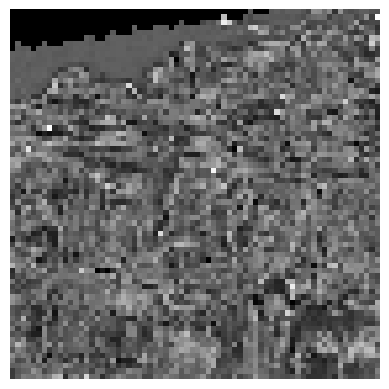

In [456]:
# Display the grayscale image
plt.imshow(frag_test_data[0][0], cmap="gray") # [fragment][train][layer][image]
plt.axis("off")
plt.show()

In [457]:
test_tensor = torch.from_numpy(frag_test_data)
test_tensor = test_tensor.to(torch.float32)

In [458]:
test_loader = DataLoader(test_tensor, batch_size=1)

In [620]:
model = torch.load('../models/ink_detection_simple_u_net_epoch_25_batch_64.pt')

model.eval()  # Set the model to evaluation mode

results_test = []

with torch.no_grad():
    for batch in test_loader:
        # Move the batch to the GPU if available
        batch = batch.to(device) if torch.cuda.is_available() else batch

        # Perform inference
        outputs = model(batch)
        results_test.append(outputs)

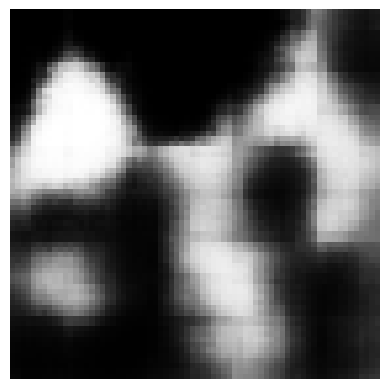

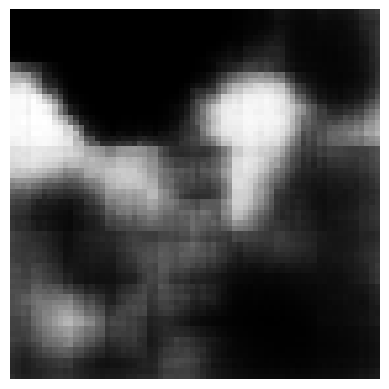

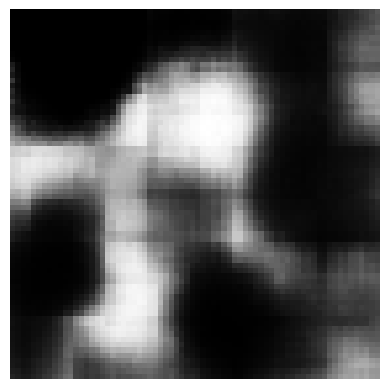

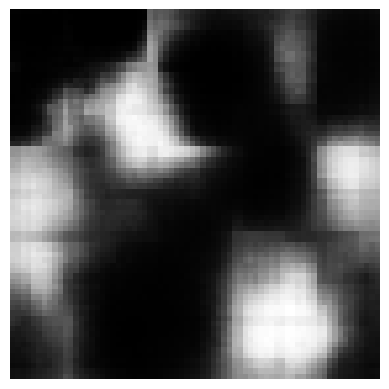

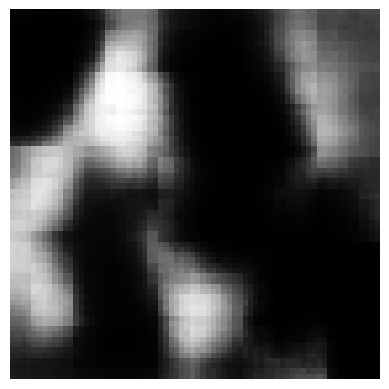

In [621]:
outputs_np = []
for result in results_test[:5]:
    # Convert the PyTorch tensor to a NumPy array
    outputs_np.append(result.cpu().numpy())

# Iterate over the outputs
for i in range(len(outputs_np)):
    output = outputs_np[i][0][0]

    # Display the output as an image
    plt.imshow(output, cmap='gray')  # Assuming grayscale images
    plt.axis('off')
    plt.show()

In [501]:
len(results_test)

366

In [636]:
#Evaluate results for validation set
frag_val_data=X_val
frag_val_data=frag_val_data[:,:layer_depth,:,:,]
frag_val_data.shape

(694, 24, 70, 70)

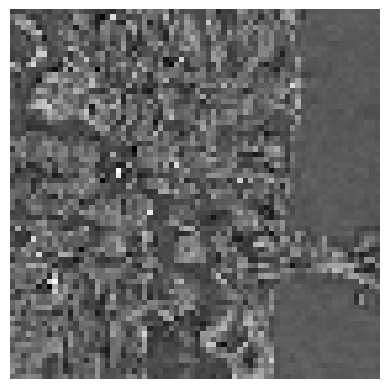

In [637]:
# Display the grayscale image
plt.imshow(frag_val_data[0][0], cmap="gray") # [fragment][train][layer][image]
plt.axis("off")
plt.show()

In [638]:
X_val.shape

(694, 24, 70, 70)

In [639]:
val_tensor = torch.from_numpy(frag_val_data)
val_dataset_tensor = val_tensor.to(torch.float32)

In [640]:
val_loader = DataLoader(val_dataset_tensor, batch_size=1)

In [641]:
results_val = []

with torch.no_grad():
    for batch in val_loader:
        # Move the batch to the GPU if available
        batch = batch.to(device) if torch.cuda.is_available() else batch

        # Perform inference
        outputs = model(batch)
        results_val.append(outputs)

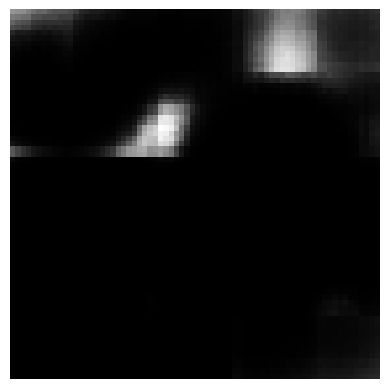

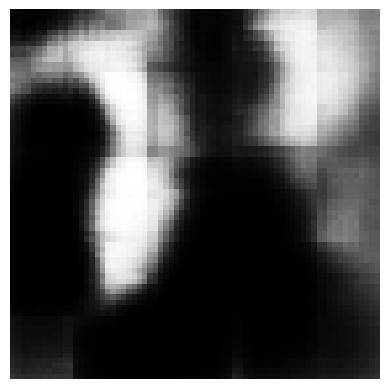

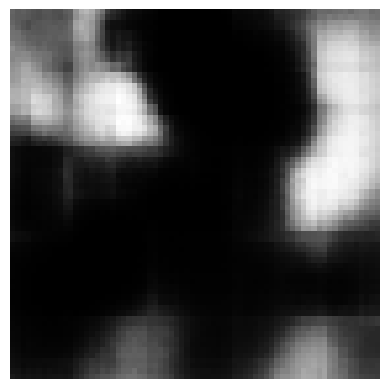

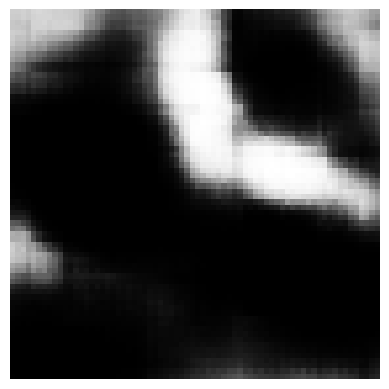

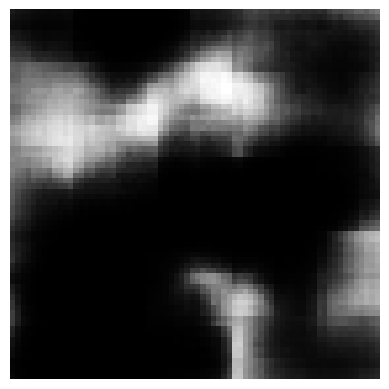

In [642]:
outputs_np = []
for result in results_val[:5]:
    # Convert the PyTorch tensor to a NumPy array
    outputs_np.append(result.cpu().numpy())

# Iterate over the outputs
for i in range(len(outputs_np)):
    output = outputs_np[i][0][0]

    # Display the output as an image
    plt.imshow(output, cmap='gray')  # Assuming grayscale images
    plt.axis('off')
    plt.show()

In [622]:
FRAGMENT_MASKED_CROPS_PATH = '../../Datasets/vesuvius-challenge-ink-detection/cropped_test/a/masked_crops.txt'
FRAGMENT_HEIGHT = 190
FRAGMENT_WIDTH = 443

In [623]:
#Stiching test results

crop_positions = get_crop_numer_list(file_name= FRAGMENT_MASKED_CROPS_PATH)

In [624]:
len(crop_positions)

366

In [625]:
stitched_image = stitch_crops(FRAGMENT_HEIGHT,FRAGMENT_WIDTH,results_test,crop_positions)

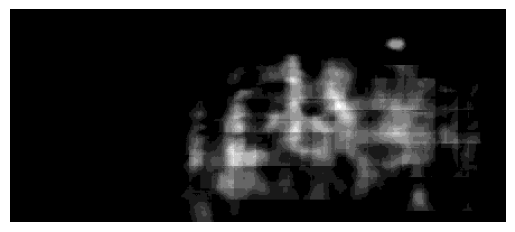

In [626]:
# Display the output as an image
plt.imshow(stitched_image, cmap='gray')  # Assuming grayscale images
plt.axis('off')
plt.show()

In [627]:
#Infer results for  fragment b

frag_test_data_b=test_dataset[1][0] #[fragment][volume/label]
frag_test_data_b=frag_test_data_b[:,:layer_depth,:,:,]
frag_test_data_b.shape

(772, 24, 70, 70)

In [628]:
test_tensor_b = torch.from_numpy(frag_test_data_b)
test_tensor_b = test_tensor_b.to(torch.float32)

In [629]:
test_loader_b = DataLoader(test_tensor_b, batch_size=1)

In [630]:
results_test_b = []

with torch.no_grad():
    for batch in test_loader_b:
        # Move the batch to the GPU if available
        batch = batch.to(device) if torch.cuda.is_available() else batch

        # Perform inference
        outputs = model(batch)
        results_test_b.append(outputs)

In [631]:
FRAGMENT_MASKED_CROPS_PATH = '../../Datasets/vesuvius-challenge-ink-detection/cropped_test/b/masked_crops.txt'
FRAGMENT_HEIGHT = 381
FRAGMENT_WIDTH = 443

In [632]:
crop_positions = get_crop_numer_list(file_name= FRAGMENT_MASKED_CROPS_PATH)

In [633]:
stitched_image = stitch_crops(FRAGMENT_HEIGHT,FRAGMENT_WIDTH,results_test_b,crop_positions)

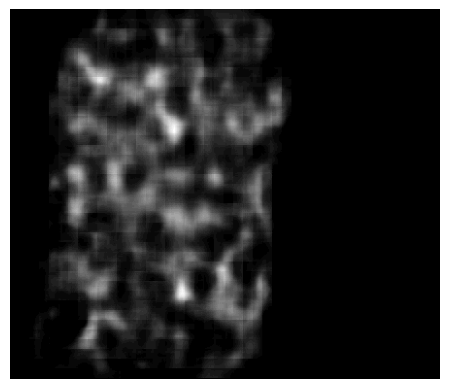

In [634]:
# Display the output as an image
plt.imshow(stitched_image, cmap='gray')  # Assuming grayscale images
plt.axis('off')
plt.show()